In [1]:
# SYSTEM
from tqdm.auto import tqdm

# MATH
import math
import numpy as np
from numpy.random import randint

# DATA
import pandas as pd
from tabulate import tabulate

# PLOTTING
import visualkeras  
import seaborn as sns
import matplotlib.pyplot as plt

# MACHINE LEARNING
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

# EVALUATION
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
def build_model(input_shape=(28, 28, 1), learning_rate=0.001, classes=10):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                    strides=1, padding='same', data_format='channels_last',
                    input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                    strides=1, padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                    strides=1, padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                    strides=1, padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(classes, activation='softmax'))

    # Optimizer
    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [3]:
MNIST_CLASS_NAMES = ['zero', 'one', 'two', 'three', 'four',
                    'five', 'six', 'seven', 'eight', 'nine']

FASHIONMNIST_CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

CIFAR10_CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                      'dog', 'frog', 'horse', 'ship', 'truck']

CIFAR100_CLASS_NAMES = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
                       'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
                       'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
                       'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
                       'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
                       'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
                       'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
                       'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
                       'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
                       'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
                       'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
                       'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
                       'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip',
                       'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']


In [4]:
class Main:
    def __init__(self, dataset, model=None, name=None, class_names=None):
        # DATA
        (self.X_train, self.y_train), (self.X_test, self.y_test) = dataset.load_data()
        
        # MODEL ARCHITECTURE
        self.model = model

        # MODEL CONFIGURATION
        self.name = name
        self.class_names = class_names

        if self.class_names is None:
            self.class_names = np.unique(self.y_train)


        self.batch_size = None
        self.epochs = None
        self.history = None        

In [5]:
class DataVisualisation(Main):
    def __init__(self, dataset, model=None, name=None, class_names=None):
        super().__init__(dataset=dataset, 
                         model=model, 
                         name=name, 
                         class_names=class_names)
        
    def plot(self, figsize=(7, 7), n=3):
        plt.figure(figsize=figsize)
        for i in range(n*n):
            plt.subplot(n, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(self.X_train[i], cmap=plt.cm.binary)
            plt.title(self.class_names[self.y_train[i]])
        plt.show()

    def get_label_df(self):
        train_df = pd.DataFrame({'training': self.y_train.squeeze()})
        test_df  = pd.DataFrame({'testing': self.y_test.squeeze()})
        return train_df, test_df

    def get_label_counts(self):
        train_df, test_df = self.get_label_df()
        train_counts = train_df['training'].value_counts().sort_index()
        test_counts  = test_df['testing'].value_counts().sort_index()
        return train_counts, test_counts

    def plot_label_count(self, figsize=(6, 4)):
        train_counts, test_counts = self.get_label_counts()

        # Create the figure and axes
        fig, ax = plt.subplots(figsize=figsize)

        # Set the x-axis and y-axis labels
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')

        # Set the title
        ax.set_title(f'Distribution of Labels in {self.name} Dataset')

        # Plot the bar graph for training and testing datasets
        train_counts.plot(kind='bar', ax=ax, color='blue', alpha=0.7, label='Training')
        test_counts.plot(kind='bar', ax=ax, color='green', alpha=0.7, label='Testing')

        # Add text inside each bar
        for i, (train_val, test_val) in enumerate(zip(train_counts, test_counts)):
            ax.text(i, train_val/2, train_val, ha='center', va='center')
            ax.text(i, train_val + test_val/2, test_val, ha='center', va='center')

        # Add a legend
        ax.legend(loc='best')
        ax.set_xticklabels(self.class_names, rotation='vertical')

        # Display the graph
        plt.show()


    def model_visualisation(self, to_file=None, legend=True, draw_volume=True,
                        spacing=30, type_ignore=None):
    
        if to_file is None:
            to_file = self.name + '.png'

        visualkeras.layered_view(self.model, to_file=to_file, legend=legend,
                                 draw_volume=draw_volume, spacing=spacing,
                                 type_ignore=type_ignore)
    
    def __str__(self):
        data = [['Training', self.X_train.shape, self.y_train.shape],
                ['Testing', self.X_test.shape, self.y_test.shape]]
        col_names = ["Images", "Labels"]
        return tabulate(data, headers=col_names, tablefmt="grid")

In [6]:
class DataPreprocessor(Main):
    def __init__(self, dataset, model=None, name=None, class_names=None):
        super().__init__(dataset=dataset, 
                         model=model, 
                         name=name, 
                         class_names=class_names)

    @staticmethod
    def get_num_channels(self, X_train):
        CHANNELS = 1
        CHANNELS = X_train.shape[3] if len(X_train.shape) == 4 else CHANNELS
        return CHANNELS
            
    def reshape_data(self, X_train, X_test):
        CHANNELS = self.get_num_channels(self, X_train)
        X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2], CHANNELS))
        X_test = X_test.reshape((-1, X_test.shape[1], X_test.shape[2], CHANNELS))
        return X_train, X_test    

    def normalise_data(self, X_train, X_test):
        X_train = X_train.astype('float32') / 255.0
        X_test = X_test.astype('float32') / 255.0
        return X_train, X_test

    def encode_target_data(self, y_train, y_test):
        NUM_CLASSES = len(np.unique(y_train))
        y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
        y_test = to_categorical(y_test, num_classes=NUM_CLASSES)
        return y_train, y_test

    def preprocess_data(self ,X_train, y_train, X_test, y_test):
        # 1. RESHAPE THE DATA for BATCHES (BATCH_SIZE, HEIGHT, WIDTH, CHANNELS)
        X_train, X_test = self.reshape_data(X_train, X_test)

        # 2. NORMALIZE THE DATA TO BE FLOAT AND DIVIDE IT BY 255
        X_train, X_test = self.normalise_data(X_train, X_test)

        # 2. ENCODE THE TARGET DATA CATEGORICALLY
        y_train, y_test = self.encode_target_data(y_train, y_test)

        return (X_train, y_train), (X_test, y_test)

    def preprocess_image(self, image):
        image = np.expand_dims(image, axis=0)
        image = image.astype('float32')
        image /= 255.0
        return image    

In [7]:
class DataEvaluator(DataPreprocessor):
    def __init__(self, dataset, model=None, name=None, class_names=None):
        super().__init__(dataset=dataset, 
                         model=model, 
                         name=name, 
                         class_names=class_names)
    
    def plot_predictions(self, n=3):
        # PREPROCESS DATA
        (X_train, y_train), (X_test, y_test) = self.preprocess_data(self.X_train, 
                                                                    self.y_train, 
                                                                    self.X_test, 
                                                                    self.y_test)

        # CREATE A 5X5 GRID OF SUBPLOTS
        fig, axes = plt.subplots(n, n, figsize=(n * 2 + 2, n * 2 + 2))

        # ADJUST THE SPACING BETWEEN SUBPLOTS
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        # GATHERING RANDOM DATA POINTS
        data = randint(0, len(X_test), n * n)

        # ITERATE OVER EACH SUBPLOT AND CUSTOMIZE
        for i, ax in enumerate(axes.flat):
            img = X_test[data[i]]
            img = np.expand_dims(img, axis=0)
            
            ax.imshow(img.squeeze(), cmap='gray')

            predict_value = self.model.predict(img, verbose=0)
            digit = np.argmax(predict_value)
            actual = np.argmax(y_test[data[i]])

            ax.set(xticks=[], yticks=[])

            title_color = 'green'

            if digit != actual:
                title_color = 'red'

            ax.set_title(f'Pred: {digit} | Actual: {actual}', color=title_color)

            for j in ['top', 'right', 'bottom', 'left']:
                ax.spines[j].set_visible(False)

        plt.show()

    def plot_confusion_matrix(self):
        # 1. PREPROCESS DATA
        (X_train, y_train), (X_test, y_test) = self.preprocess_data(self.X_train, 
                                                                    self.y_train, 
                                                                    self.X_test, 
                                                                    self.y_test)

        y_test = np.argmax(y_test, axis=1)

        y_prediction = self.model.predict(X_test, verbose=0)
        y_prediction = np.argmax(y_prediction, axis=1)

        result = confusion_matrix(y_test, y_prediction)

        plt.figure(figsize=(8, 6))
        ax = plt.gca()

        # Create a heatmap of the confusion matrix
        sns.heatmap(result, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

        # Set labels, title, and ticks
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix for {self.name}')
        ax.xaxis.set_ticklabels(self.class_names, rotation=90)
        ax.yaxis.set_ticklabels(self.class_names, rotation=0)
        plt.show()

    def plot_metric(self, figsize=(10, 6), metric='accuracy'):
        plt.figure(figsize=figsize)

        target = ['Training', 'Validation']
        color = ['blue', 'orange']
        linestyle = ['-', '--']
        val = ''

        X = [x+1 for x in range(len(self.history.history[metric]))]
        
        plt.grid(True)
        sns.set(style="darkgrid")
        for i in range(2):
            y = self.history.history[val + metric]
            sns.lineplot(x=X, y=y, marker='o', markersize=6, color=color[i],
                         linewidth=2.5, linestyle=linestyle[i], label=target[i])

            value = max(y)
            if 'loss' in metric:
                value = min(y)

            max_index = y.index(value)
            plt.text(X[max_index], value, f"{value:.2f}", 
                     ha='center', va='bottom')
            val += 'val_'

        # Set plot labels and title
        plt.xlabel("Epochs")
        plt.ylabel(metric.title())
        plt.title(metric.title() + ' Plot')

        plt.xticks(X, [str(x) for x in X])

        # Show the plot
        plt.show()

In [8]:
class Model(DataVisualisation, DataEvaluator):
    def __init__(self, dataset, model=None, name=None, class_names=None):
        super().__init__(dataset=dataset, 
                         model=model, 
                         name=name, 
                         class_names=class_names)
        
    @staticmethod
    def step_decay(epoch, lr):
        if epoch % 10 == 0:
          lr *= 0.1
          return lr
        return lr

    @staticmethod
    def cosine_annealing(epoch, initial_lr, total_epochs):
      lr = 0.5 * initial_lr * (1 + math.cos(math.pi * epoch / total_epochs))
      return lr      
        
    def train_model(self, input_shape=(28, 28, 1), 
                    learning_rate=0.001,
                    batch_size=64, 
                    epochs=20):
        
        # PREPROCESS DATA
        (X_train, y_train), (X_test, y_test) = self.preprocess_data(self.X_train, 
                                                                    self.y_train, 
                                                                    self.X_test, 
                                                                    self.y_test)
       
        self.batch_size = batch_size
        self.epochs = epochs

        reduce_lr = LearningRateScheduler(lambda epoch: self.cosine_annealing(epoch, 
                                                                              learning_rate, 
                                                                              epochs))
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

        self.history = self.model.fit(X_train, y_train, batch_size,
                                      epochs=self.epochs,
                                      validation_data=(X_test, y_test),
                                      verbose=1,
                                      steps_per_epoch=len(self.X_train) / batch_size,
                                      callbacks=[reduce_lr, early_stopping])    

    def save_model(self, name=None):
        if name is None:
            name = self.name + '_e' + str(self.epochs) + '_bS' + str(self.batch_size) + '.h5'
        self.model.save(name)

    def predict(self, image):
        image = self.preprocess_image(image)
        y_prediction = self.model.predict(image, verbose=0)
        y_prediction = np.argmax(y_prediction, axis=1)  
        return y_prediction.squeeze()

    def __str__(self):
        return super().__str__()

# Training

In [10]:
model = build_model()
MNIST = Model(dataset=mnist, model=model, 
              name='mnist', class_names=MNIST_CLASS_NAMES)
print(MNIST)

+----------+-----------------+----------+
|          | Images          | Labels   |
+==========+=================+==========+
| Training | (60000, 28, 28) | (60000,) |
+----------+-----------------+----------+
| Testing  | (10000, 28, 28) | (10000,) |
+----------+-----------------+----------+


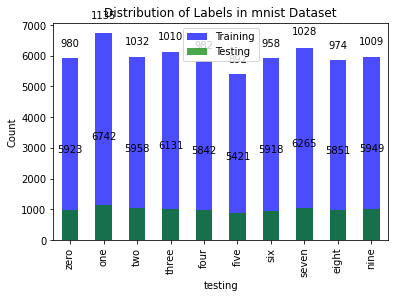

In [11]:
MNIST.plot_label_count()

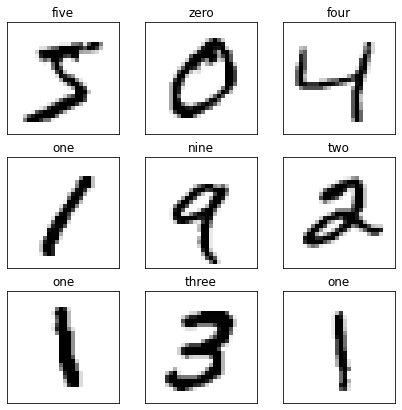

In [12]:
MNIST.plot()

In [13]:
MNIST.train_model(epochs=1)

937/937 [==============================] - 24s 24ms/step - loss: 0.1659 - accuracy: 0.9522 - val_loss: 0.0650 - val_accuracy: 0.9808 - lr: 0.0010


In [14]:
MNIST.model_visualisation()

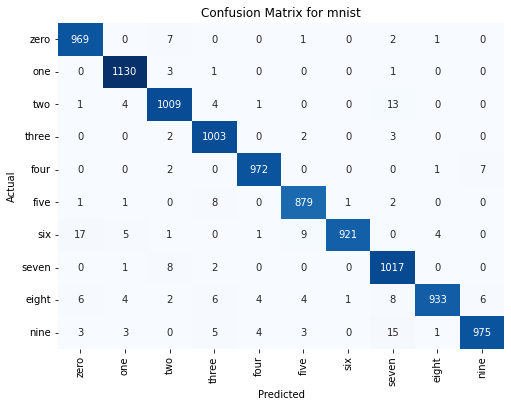

In [15]:
MNIST.plot_confusion_matrix()

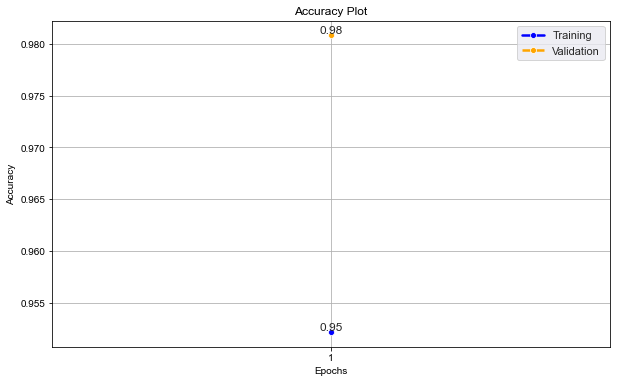

In [16]:
MNIST.plot_metric()

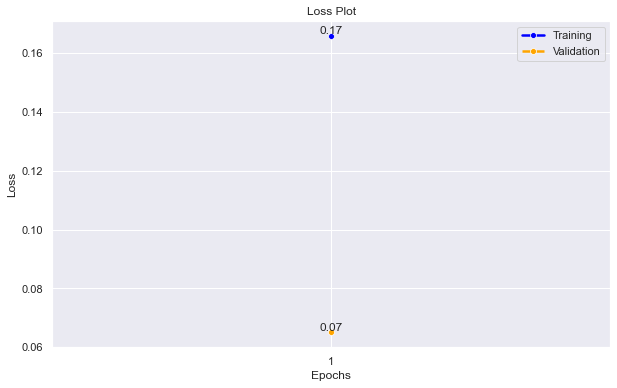

In [17]:
MNIST.plot_metric(metric='loss')

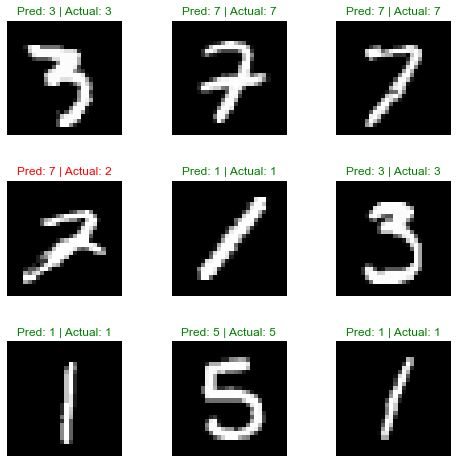

In [18]:
MNIST.plot_predictions()

In [21]:
(X_train, y_train), (X_test, y_test) = MNIST.preprocess_data(MNIST.X_train, 
                                                            MNIST.y_train, 
                                                            MNIST.X_test, 
                                                            MNIST.y_test)

MNIST.predict(X_test[0]), np.argmax(y_test[0])

(array(1), 7)

In [ ]:
(count/len(X_test)) * 100

In [ ]:
np.argmax(np.where(y_test[1] == 1))

In [ ]:
np.argmax(np.where(y_test == 1))

In [ ]:
one_count = 0

for i in tqdm(range(len(y_test))):
    actual = np.argmax(y_test[i])
    if actual == 1:
        one_count+=1

one_count

In [22]:
PREDICTIONS = MNIST.model.predict(X_test)

313/313 [==============================] - 1s 4ms/step


In [24]:
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Accuracy: {accuracy*100:.2f}%")

313/313 [==============================] - 3s 9ms/step - loss: 0.0650 - accuracy: 0.9808
Accuracy: 98.08%


In [34]:
from sklearn.metrics import classification_report

# Convert the predictions to class labels
predicted_labels = np.argmax(PREDICTIONS, axis=1)

# Generate the classification report
classification_rep = classification_report(MNIST.y_test, predicted_labels)
print(classification_rep)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       1.00      0.96      0.98       958
           7       0.96      0.99      0.97      1028
           8       0.99      0.96      0.97       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

